<a href="https://colab.research.google.com/github/condusinew/vaccine_failure_escape/blob/main/seed_natimm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

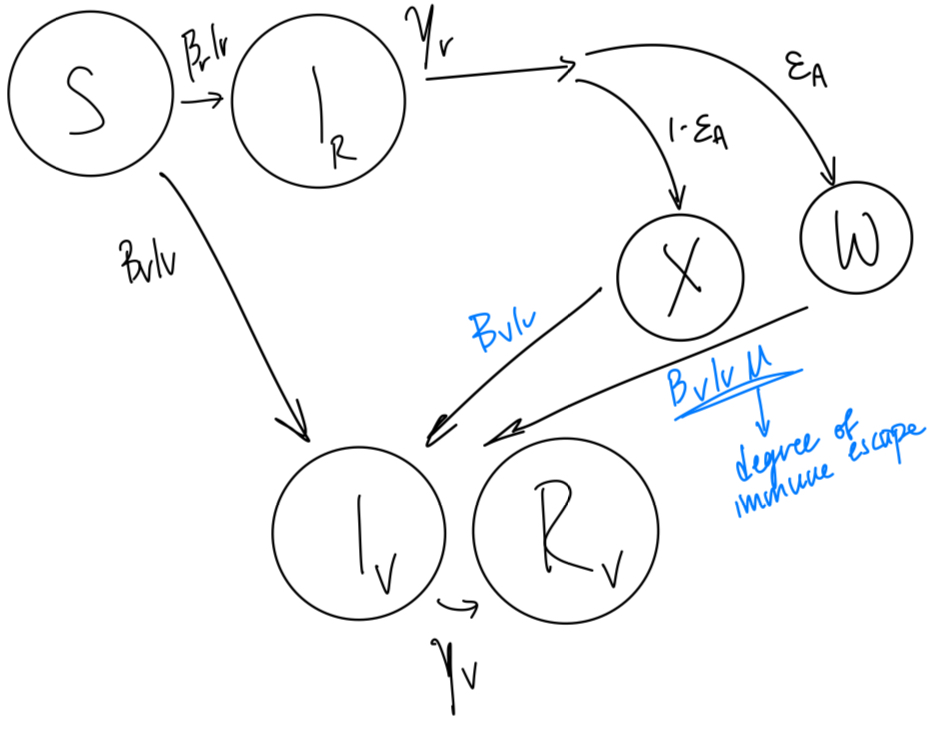

$\frac{\mathrm{d}S}{\mathrm{d}t} = -(\beta_r I_r + \beta_v I_v)S$

$\frac{\mathrm{d}I_r}{\mathrm{d}t} = \beta_r I_r [S+N+(1-\epsilon_L) P] - \gamma_r I_r $

$\frac{\mathrm{d}N}{\mathrm{d}t} = (1-\epsilon_a)\gamma_rI_r - (\beta_v I_v + \beta_r I_r) N $

$\frac{\mathrm{d}P}{\mathrm{d}t} = \epsilon_a\gamma_rI_r - \beta_r I_r(1-\epsilon_L)P - \beta_v I_v (1-(1-\mu)\epsilon_L) P$

$\frac{\mathrm{d}I_v}{\mathrm{d}t} = \beta_v I_v [S + N + (1-(1-\mu)\epsilon_L)] P - \gamma_v I_v$

$\frac{\mathrm{d}R_v}{\mathrm{d}t} = \gamma_v I_v$

#MUST RUN

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# SIR model equations
def SIR_model_rv(t, y, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL):
    S, Iw, N, P, Im, Rm, CIw, CIm  = y

    dSdt = -(betaw*Iw+ betam*Im) * S
    dIwdt = betaw * Iw* (S + N + (1-epsilonL)*P)  - gammaw * Iw

    dNdt = (1-epsilona)*gammaw * Iw - (betam*Im+betaw*Iw) *N
    dPdt = epsilona * gammaw * Iw-betaw*Iw*(1-epsilonL)*P - betam*Im*(1-((1-mu)*epsilonL))*P

    dImdt = betam*Im*(S + N +(1-((1-mu)*epsilonL))*P) - gammam * Im
    dRmdt = gammam * Im

    dCIwdt = betaw * Iw* (S + N + (1-epsilonL)*P)
    dCImdt = betam*Im*(S + N +(1-((1-mu)*epsilonL))*P)

    return [dSdt, dIwdt, dNdt, dPdt, dImdt, dRmdt, dCIwdt, dCImdt]


In [3]:
#ALWAYS RUN
CIm0 = 0
CIw0 = 0

In [4]:
def _reach_size(t, y, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL):
    return (y[2]+y[3]) - recovered_threshold #its all recovered ppl
    _reach_size.terminate = True

#FUNCTION TO FIND TIME OF VARIANT RISING
def find_tv(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL):
  sol_findtv = solve_ivp(SIR_model_rv, [0,t], y0,
                  args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
                  events=_reach_size, t_eval = np.linspace(0, t, t)) #changed dense output to np.linspace

  # get tv and seed Iv
  tv = np.ravel(np.array(sol_findtv.t_events))[0]

  return tv

def solve_seeded(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL):
  tv = find_tv(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)
  print("linspace num =", tv, type(tv))

  sol1 = solve_ivp(SIR_model_rv, [0,tv], y0,
                  args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
                  t_eval = np.linspace(0, tv, t))

  #last timepoint at tv
  y_tv = sol1.y[:, -1]

  #seed small fraction from Iw into Im
  y_tv[1] -= fraction_seed
  y_tv[4] = fraction_seed

  #second part of solution, after tv
  sol2 = solve_ivp(
      SIR_model_rv,
      [tv, t], # start at tv
      y_tv, # use updated initial condition
      args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
      t_eval = np.linspace(tv, t, t)
  )

  #make into one full soln
  t_full = np.concatenate([sol1.t, sol2.t])
  y_full = np.hstack([sol1.y, sol2.y])

  return([t_full, y_full])
#FIX SO THAT IF RECOVERED PART NOT REACHED IT DOESNT BEAK
#VERSION OF FIND TV THAT RETURNS NONE IF DOESNT FIND TV, THEN FIX SOLVE_SEEDED SO IT SOLVES REGULARLY OTHERWISE

def find_finalCIw(solution_y):
  S, Iw, N, P, Im, Rm, CIw, CIm  = solution.y
  return(CIw[-1])

def find_finalCIm(solution_y):
  S, Iw, N, P, Im, Rm, CIw, CIm  = solution.y
  return(CIm[-1])


In [5]:
#plotting functions
def plot_basic(t_full, y_full, figsize = (10, 6), ax=None, title="SIR sim w variant seeded", ylim_max = 1):
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)

    S, Iw, N, P, Im, Rm, CIw, CIm  = y_full

    ax.plot(t_full, S, label='Susceptible')
    ax.plot(t_full, Iw, label='Infected (wildtype)')
    ax.plot(t_full, Im, label='Infected (mutant)')
    ax.plot(t_full, Rm, label='Recovered (mutant)')
    ax.plot(t_full, N, label='Immunity_none')
    ax.plot(t_full, P, label='Immunity_leaky')

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Proportion of Population')
    ax.set_title(title)
    ax.set_ylim(0, ylim_max)
    ax.legend()
    ax.grid(True)

    return ax

def plot_cum(solution, ax=None, title="Cumulative infections", ylim_max = 1):
    if ax is None:
        fig, ax = plt.subplots()

    t = solution.t
    *_, CIw, CIm = solution.y

    ax.plot(t, CIw, label="Cumulative WT")
    ax.plot(t, CIm, label="Cumulative variant")

    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Cumulative incidence")
    ax.set_title(title)
    ax.set_ylim(0, ylim_max)
    ax.legend()
    ax.grid(True)

    return ax


#Stress-Testing scenarios - 2 strain only

1. Two-strain model, variant exists when recovered > 0.1. Natural immunity confers perfect protection against all variants (mu = 0, epsilonL = 1, epsilonA = 1).

P and Rm are absorbing compartments. Im should decrease to 0 fast due to low immune escape properties

In [6]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.6
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.6
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0
epsilona = 1
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

In [7]:
#do solution up to tv
tv = find_tv(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)

sol1 = solve_ivp(SIR_model_rv, [0,tv], y0,
                 args=(mu, betaw, gammaw, betam, gammaw, epsilona, epsilonL),
                 t_eval = np.linspace(0, tv, t))

#last timepoint at tv
y_tv = sol1.y[:, -1]

#seed small fraction from Iw into Im
y_tv[1] -= fraction_seed
y_tv[4] = fraction_seed

#second part of solution, after tv
sol2 = solve_ivp(
    SIR_model_rv,
    [tv, t], # start at tv
    y_tv, # use updated initial condition
    args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
    t_eval = np.linspace(tv, t, t)
)

#make into one full soln
t_full = np.concatenate([sol1.t, sol2.t])
y_full = np.hstack([sol1.y, sol2.y])
S, Iw, N, P, Im, Rm, CIw, CIm  = y_full


<Axes: title={'center': 'SIR sim w variant seeded'}, xlabel='Time (days)', ylabel='Proportion of Population'>

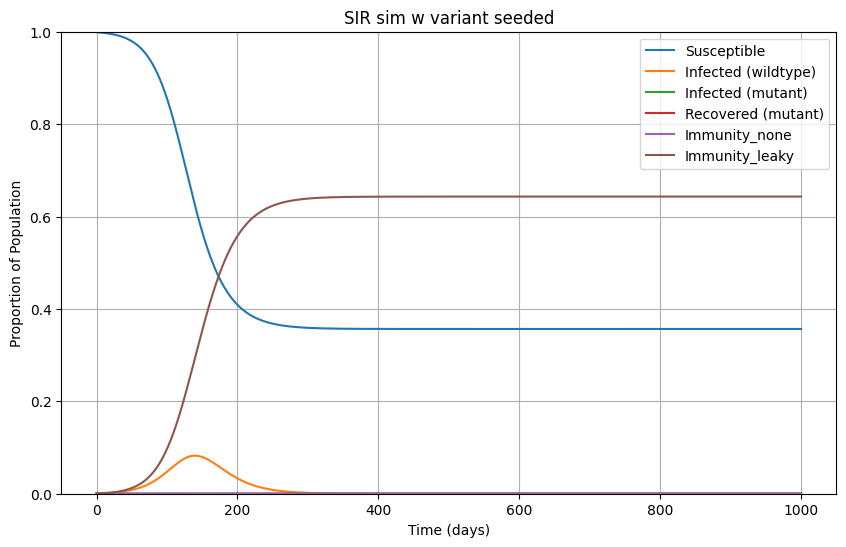

In [8]:
plot_basic(t_full, y_full)

## 7. Two-strain model. Natural immunity confers no protection against any variants, all go to N. Epsilon_A = 0. Immune escape does not matter.

Will see a lot more R_v compared to previous scenario, as the only absorbing compartment. Infected reaches higher final epidemic size and faster as more of the population stays susceptible for longer compared to previous scenario.

In [7]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.6
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.6
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0
epsilona = 0
epsilonL = 1
t = 10000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

linspace num = 212.35029768816446 <class 'numpy.float64'>


<Axes: title={'center': 'SIR sim w variant seeded'}, xlabel='Time (days)', ylabel='Proportion of Population'>

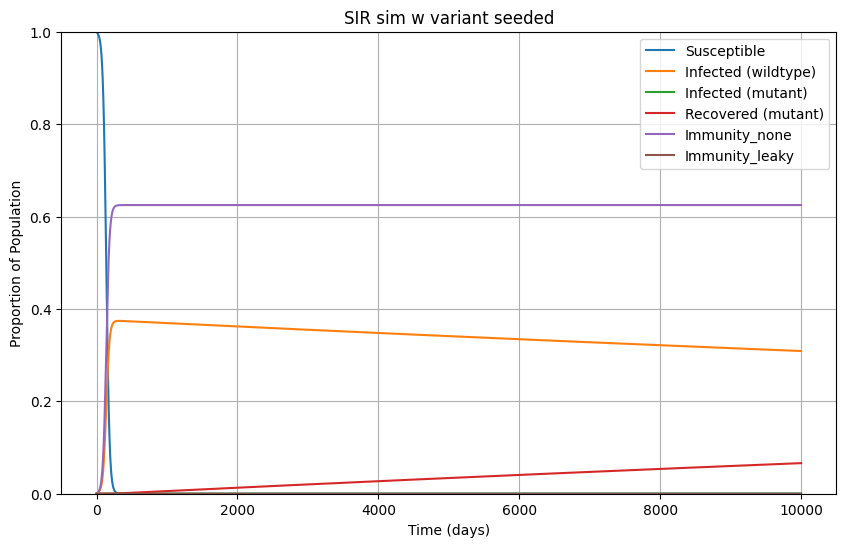

In [13]:
t_full, y_full = solve_seeded(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)

S, Iw, N, P, Im, Rm, CIw, CIm  = y_full
plot_basic(t_full, y_full)



## 7. Two-strain model, all-or-nothing immunity. Epsilon_A = 0.5. Epsilon_L = 1. Immune escape (mu) does matter, as mutant can affect that with perfect protection against wildtype

Im will do better than Iw due to selective advantage that appears once many have recovered? (not true). Only half of recovered pop'n gets selective advantage?  In past model, Im peaked later than Iw, with a lower peak. Seems similar, though less cumulative Im infections, though perhaps more total days infected? see with heatmaps

<Axes: title={'center': 'SIR sim w variant seeded'}, xlabel='Time (days)', ylabel='Proportion of Population'>

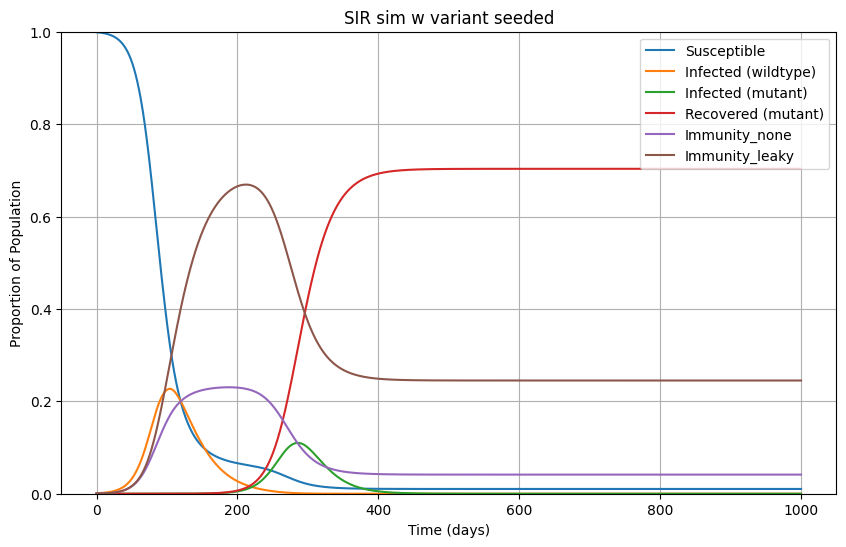

In [11]:
# set parameter values
#betaw = 1.1
Rwnaught = 2
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 2.5
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 0.5
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

#do solution up to tv
tv = find_tv(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)

sol1 = solve_ivp(SIR_model_rv, [0,tv], y0,
                 args=(mu, betaw, gammaw, betaw, gammaw, epsilona, epsilonL),
                 t_eval = np.linspace(0, tv, t))

#last timepoint at tv
y_tv = sol1.y[:, -1]

#seed small fraction from Iw into Im
y_tv[1] -= fraction_seed
y_tv[4] = fraction_seed

#second part of solution, after tv
sol2 = solve_ivp(
    SIR_model_rv,
    [tv, t], # start at tv
    y_tv, # use updated initial condition
    args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
    t_eval = np.linspace(tv, t, t)
)

#make into one full soln
t_full = np.concatenate([sol1.t, sol2.t])
y_full = np.hstack([sol1.y, sol2.y])
S, Iw, N, P, Im, Rm, CIw, CIm  = y_full

plot_basic(t_full, y_full)


## 9. Two-strain model, variant exists at t=0. Leaky immunity (epsilon_A = 0.0, epsilon_L ϵ (0,1))

Greater epidemic size than all-or-nothing model in previous version. All of recovered popn is affected by immune escape, so maybe betetr?

<Axes: title={'center': 'SIR sim w variant seeded'}, xlabel='Time (days)', ylabel='Proportion of Population'>

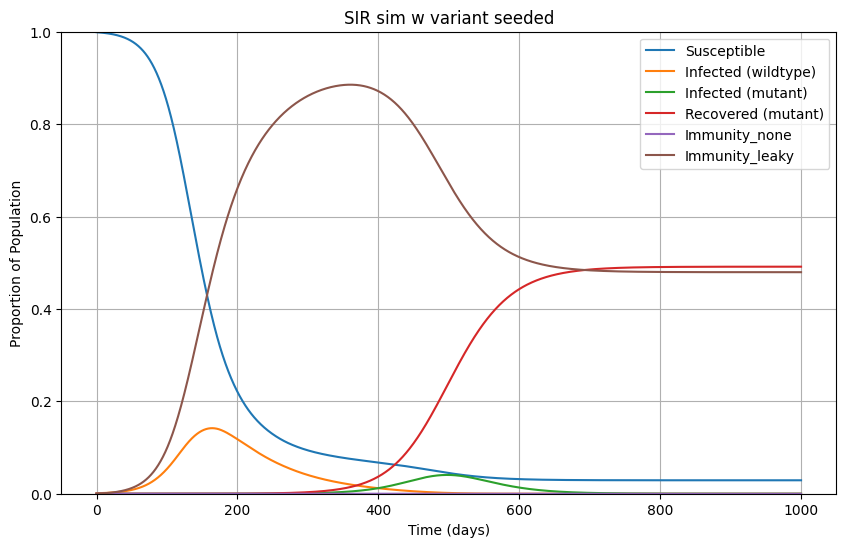

In [12]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.6
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.7
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 1
epsilonL = 0.5
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

#do solution up to tv
tv = find_tv(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)

sol1 = solve_ivp(SIR_model_rv, [0,tv], y0,
                 args=(mu, betaw, gammaw, betaw, gammaw, epsilona, epsilonL),
                 t_eval = np.linspace(0, tv, t))

#last timepoint at tv
y_tv = sol1.y[:, -1]

#seed small fraction from Iw into Im
y_tv[1] -= fraction_seed
y_tv[4] = fraction_seed

#second part of solution, after tv
sol2 = solve_ivp(
    SIR_model_rv,
    [tv, t], # start at tv
    y_tv, # use updated initial condition
    args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
    t_eval = np.linspace(tv, t, t)
)

#make into one full soln
t_full = np.concatenate([sol1.t, sol2.t])
y_full = np.hstack([sol1.y, sol2.y])
S, Iw, N, P, Im, Rm, CIw, CIm  = y_full

plot_basic(t_full, y_full)


#10. all who recover from wildtype have perfect immunity against wildtype, but. are still susceptible to mutant (epsilons=1, mu >0)

<Axes: title={'center': 'SIR sim w variant seeded'}, xlabel='Time (days)', ylabel='Proportion of Population'>

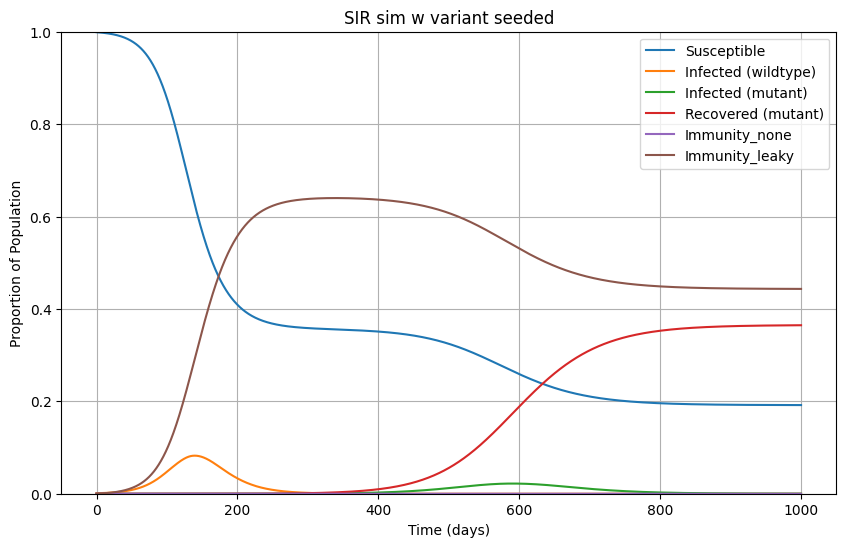

In [13]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.6
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.7
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 1
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

#do solution up to tv
tv = find_tv(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)

sol1 = solve_ivp(SIR_model_rv, [0,tv], y0,
                 args=(mu, betaw, gammaw, betaw, gammaw, epsilona, epsilonL),
                 t_eval = np.linspace(0, tv, t))

#last timepoint at tv
y_tv = sol1.y[:, -1]

#seed small fraction from Iw into Im
y_tv[1] -= fraction_seed
y_tv[4] = fraction_seed

#second part of solution, after tv
sol2 = solve_ivp(
    SIR_model_rv,
    [tv, t], # start at tv
    y_tv, # use updated initial condition
    args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
    t_eval = np.linspace(tv, t, t)
)

#make into one full soln
t_full = np.concatenate([sol1.t, sol2.t])
y_full = np.hstack([sol1.y, sol2.y])
S, Iw, N, P, Im, Rm, CIw, CIm  = y_full

plot_basic(t_full, y_full)


#11. intermediate where some recovered indivs have NO protection, and some indivs have partial protection (and they're still more susceptible to mutant). 0 < epsilons < 1, mu > 0

<Axes: title={'center': 'SIR sim w variant seeded'}, xlabel='Time (days)', ylabel='Proportion of Population'>

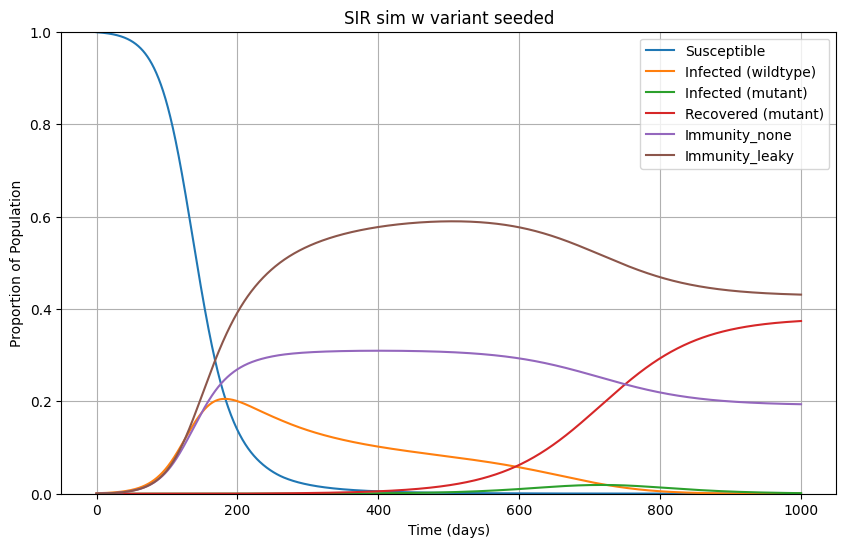

In [14]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.6
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.7
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0.3
epsilona = 0.5
epsilonL = 0.5
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

#do solution up to tv
tv = find_tv(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)

sol1 = solve_ivp(SIR_model_rv, [0,tv], y0,
                 args=(mu, betaw, gammaw, betaw, gammaw, epsilona, epsilonL),
                 t_eval = np.linspace(0, tv, t))

#last timepoint at tv
y_tv = sol1.y[:, -1]

#seed small fraction from Iw into Im
y_tv[1] -= fraction_seed
y_tv[4] = fraction_seed

#second part of solution, after tv
sol2 = solve_ivp(
    SIR_model_rv,
    [tv, t], # start at tv
    y_tv, # use updated initial condition
    args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
    t_eval = np.linspace(tv, t, t)
)

#make into one full soln
t_full = np.concatenate([sol1.t, sol2.t])
y_full = np.hstack([sol1.y, sol2.y])
S, Iw, N, P, Im, Rm, CIw, CIm  = y_full

plot_basic(t_full, y_full)


#MODULATING MU & PLOTTING RELATIVE FREQUENCIES

##SANITY CHECK

In [15]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.6
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.7
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0.3
epsilona = 1
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.6 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

In [16]:
#function for plotting any two compartment curves (eg. Iw) for many scenarios, with only one (hence mono) specified param (eg. mu) being modulated
def plot_many_mono_anytwo(param, compartment1 = "Iw", compartment2 = "Im", figsize=(15, 6), ylim_max = 1, **kwargs):
  #must send kwargs as a dictionary with (param val) as as keysn, values being solutions

  fig = plt.figure(facecolor="w", figsize=figsize)

  #resident subplot
  ax1 = fig.add_subplot(121, axisbelow=True)
  ax2 = fig.add_subplot(122, axisbelow=True)

  for key, solution in kwargs.items():
    S, Iw, N, P, Im, Rm, CIw, CIm =  solution[1] #takes solution out from list
    t = solution[0]

    curves = {
            "S": S,
            "Iw": Iw,
            "N": N,
            "P": P,
            "Im": Im,
            "Rm": Rm,
            "CIm":CIm,
            "CIw":CIw
        }

    label = f"{param} = {key}"
    ax1.plot(t, curves[compartment1], label=label, alpha=0.5)
    ax2.plot(t, curves[compartment2], label=label, alpha=0.5)

  ax1.set_xlabel('Time (days)')
  ax1.set_ylabel((f"{compartment1}"))
  ax1.set_ylim(0,ylim_max)
  ax1.grid(linewidth=0.5)
  legend = ax1.legend()
  legend.get_frame().set_alpha(0.5)

  ax2.set_xlabel('Time (days)')
  ax2.set_ylabel(f"{compartment2}")
  ax2.set_ylim(0,ylim_max)
  ax2.grid(linewidth=0.5)
  legend = ax2.legend()
  legend.get_frame().set_alpha(0.5)


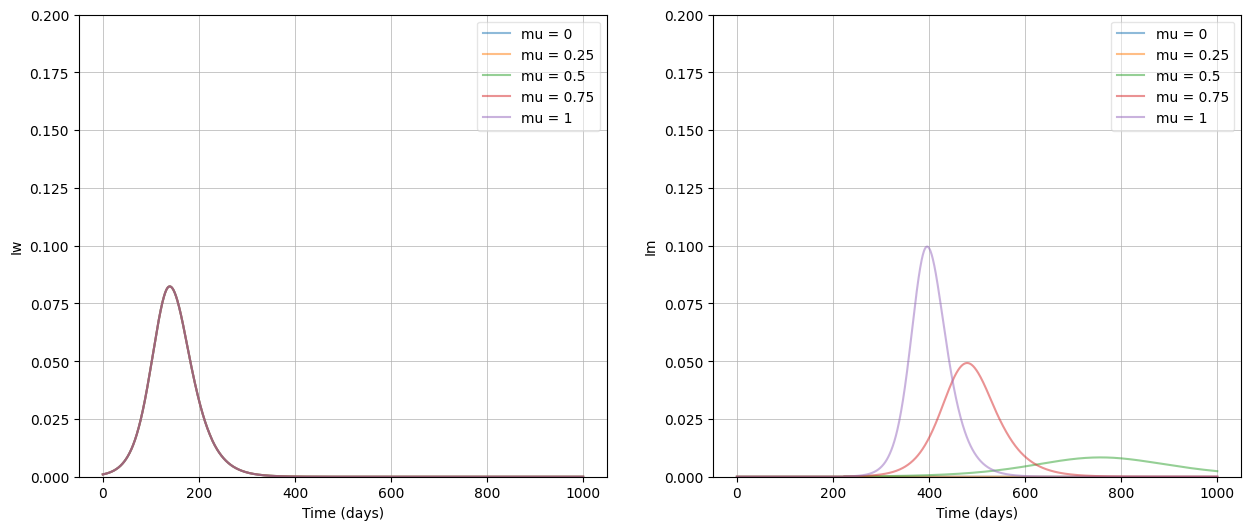

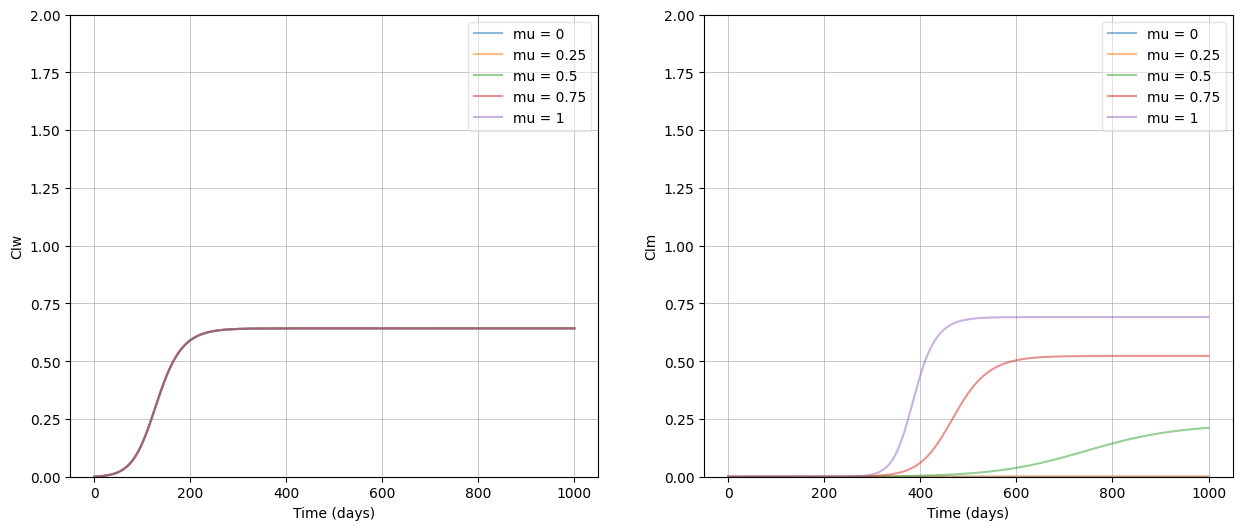

In [17]:
#list of MU
mus = [0, 0.25, 0.5, 0.75, 1] #mu being degre of immune escape, closer to 1 means more escape

kwargs = {}
solutions = []

#loop thru epsilon values and solve to get many solutions at same protection level
for i in range(len(mus)):
  #do solution up to tv
  mu = mus[i]
  tv = find_tv(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)
  sol1 = solve_ivp(SIR_model_rv, [0,tv], y0,
                  args=(mu, betaw, gammaw, betaw, gammaw, epsilona, epsilonL),
                  t_eval = np.linspace(0, tv, t))

  #last timepoint at tv
  y_tv = sol1.y[:, -1]

  #seed small fraction from Iw into Im
  y_tv[1] -= fraction_seed
  y_tv[4] = fraction_seed

  #second part of solution, after tv
  sol2 = solve_ivp(
      SIR_model_rv,
      [tv, t], # start at tv
      y_tv, # use updated initial condition
      args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
      t_eval = np.linspace(tv, t, t)
  )

  #make into one full soln
  t_full = np.concatenate([sol1.t, sol2.t])
  y_full = np.hstack([sol1.y, sol2.y])

  solutions.append([t_full, y_full])
  kwargs[str(mus[i])] = solutions[i]

plot_many_mono_anytwo("mu",ylim_max = 0.20,**kwargs)
plot_many_mono_anytwo("mu", compartment1="CIw" , compartment2= "CIm", ylim_max = 2,**kwargs)

# **HEATMAPS**

##goals

- Is there a difference in all-or-nothing vs leaky in proportional reduction of infections? If so, what directions?
- At what levels of immunity, R0s, and mu(?) is the difference more pronounced?
- ^ For two strain, need to consider the possibility of how different the R0s are
- What is the effect of the variant on cumulative infections/total infection days?

In [28]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.6
gammaw = 1/14
betaw = gammaw*Rwnaught
#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population

Rmnaught = 1.7
gammam = 1/14
betam = Rmnaught*gammam
#Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0.3
epsilona = 1
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 0
Iw0 = 1-(S0+N0+P0+Rm0) #need to get this seeded later

recovered_threshold = 0.01 # run sir model (with no variant) until R = 0.1
fraction_seed = 0.0001

In [22]:
one_strain_df = pd.DataFrame(columns=['overall_immunity', 'epsilon_a', 'epsilon_L',
                                      'mu', 'total inf_days wildtype', 'one-wave or endemic',
                                      "peak Iw", 'equil_Iw'])

two_strain_df = pd.DataFrame(columns=['overall_immunity', 'epsilon_a', 'epsilon_L',
                                      'mu', 'total reduction in inf_days wildtype',
                                      'total reduction in inf_days mutant',
                                      'total reduction in inf_days ALL',
                                      'one-wave or endemic wild', "peak Iw", 'equil_Iw',
                                      'one-wave or endemic mut', "peak Im", 'equil_Im'])

In [23]:
epsilona_vals = np.linspace(0.05, 1, 20)
immunity_vals = np.linspace(0.05, 1, 20)
Rnaughts = [1, 1.5, 2, 2.5, 8]
mus = [0, 0.35, 0.7, 1]


In [24]:
tv = find_tv(t, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL)

In [29]:
for mu in mus:
  for Rnaught in Rnaughts:
    print(type(mu), type(Rnaught), type(betaw), type(gammaw), type(gammam), type(betam), type(epsilona), type(epsilonL), type(t))
    full_sol = solve_seeded(t, mu, Rnaught*gammaw, gammaw, Rnaught*gammam, gammam, 0, 0)
    #t_full = full_sol[0]
    #y_full = full_sol[1]

<class 'int'> <class 'int'> <class 'float'> <class 'float'> <class 'float'> <class 'float'> <class 'int'> <class 'int'> <class 'int'>
linspace num = 141.4141414200476 <class 'numpy.float64'>
<class 'int'> <class 'float'> <class 'float'> <class 'float'> <class 'float'> <class 'float'> <class 'int'> <class 'int'> <class 'int'>
linspace num = 50.52339776436113 <class 'numpy.float64'>
<class 'int'> <class 'int'> <class 'float'> <class 'float'> <class 'float'> <class 'float'> <class 'int'> <class 'int'> <class 'int'>
linspace num = 33.82994339506175 <class 'numpy.float64'>
<class 'int'> <class 'float'> <class 'float'> <class 'float'> <class 'float'> <class 'float'> <class 'int'> <class 'int'> <class 'int'>
linspace num = 26.100498461099036 <class 'numpy.float64'>
<class 'int'> <class 'int'> <class 'float'> <class 'float'> <class 'float'> <class 'float'> <class 'int'> <class 'int'> <class 'int'>
linspace num = 8.695012034960284 <class 'numpy.float64'>
<class 'float'> <class 'int'> <class 'fl

In [ ]:
for mu in mus:
  for Rnaught in Rnaughts:
    full_sol = solve_seeded(mu, Rnaught*gammaw, gammaw, Rnaught*gammam, gammam, 0, 0)
    t_full = full_sol[0]
    y_full = full_sol[1]

    no_imm_totaldays_W = find_finalCIw(y_full)*(1/gammaw)
    no_imm_totaldays_M =  find_finalCIm(y_full)*(1/gammam)
    no_imm_totaldays_ALL = no_imm_totaldays_W+no_imm_totaldays_M

    for eps_A in epsilona_vals:
      for overall_imm in immunity_vals:
        eps_L = (overall_imm.round(3))/(eps_A.round(3))

        #not all epsilons are valid
        if eps_L > 1:
          continue

        solve_seeded(mu, Rnaught*gammaw, gammaw, Rnaught*gammam, gammam, epsilona, epsilonL)

        total_infected_days_W = find_finalCIw(y_full)*(1/gammaw)
        total_infected_days_M = find_finalCIm(y_full)*(1/gammam)
        total_infected_days_WM = total_infected_days_W + total_infected_days_M


        totalred_days_W = (no_imm_totaldays_W - total_infected_days_W)/no_imm_totaldays_W
        totalred_days_M = (no_imm_totaldays_M - total_infected_days_M)/no_imm_totaldays_M

        total_reduction_days = (no_imm_totaldays_ALL - total_infected_days_WM)/no_imm_totaldays_ALL

        #add to df
        two_strain_df.loc[len(two_strain_df)] = [overall_imm.round(3),
                                      eps_A.round(3),
                                      eps_L.round(3),
                                      mu,
                                      Rnaught,
                                      totalred_days_W,
                                      totalred_days_M,
                                      total_reduction_days,
                                      Iw_wave_or_end(solution),
                                      find_Iw_peak(solution, Iw_wave_or_end(solution)),
                                      find_Iw_equil(solution, Iw_wave_or_end(solution)),
                                      Im_wave_or_end(solution),
                                      find_Im_peak(solution, Im_wave_or_end(solution)),
                                      find_Im_equil(solution, Im_wave_or_end(solution)),
                                      total_infected_days_W,
                                      total_infected_days_M
                                      ]
